# Phase 4 Project - Time Series Modeling Introduction

### By Rachel Beery

## Overview

### In this project we are using a time series model to understand the patterns of natural disasters declarations in the United States. By understanding these patterns we will then provide recommendations on what natural disasters to prepare for and when they may occur. 

Source: https://www.fema.gov/openfema-data-page/disaster-declarations-summaries-v2 

In [1]:
# We will begin by importing all of the packages we anticipate to use
import pandas as pd
import pandas.tseries  
import numpy as np  

import statsmodels.api as sm 
import itertools

import matplotlib.pyplot as plt   
from matplotlib.pylab import rcParams 
%matplotlib inline
plt.style.use('ggplot') 
import plotly.express as px
import plotly.figure_factory as ff 
import plotly.graph_objects as go 
import seaborn as sns  

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Setting the display defaults
pd.set_option('display.max_columns', 0)
# pd.set_option('display.max_rows',)

# Turning off scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:

#Import data and see the headers
df = pd.read_csv(r"DisasterDeclarationsSummaries.csv")
df.head()

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,hash,lastRefresh,id
0,DR-1-GA,1,GA,DR,1953-05-02T04:00:00.000Z,1953,Tornado,TORNADO,0,1,1,1,1953-05-02T04:00:00.000Z,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,2f28952448e0a666d367ca3f854c81ec,2020-10-05T14:21:20.694Z,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15T04:00:00.000Z,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15T04:00:00.000Z,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,c5a1a4a1030d6730d9c562cdbe7c830f,2020-10-05T14:21:20.696Z,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06T04:00:00.000Z,1953,Flood,FLOODS,0,1,1,1,1953-06-06T04:00:00.000Z,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,59c5483387ca13c6a3c1bc692f4860e1,2020-10-05T14:21:20.698Z,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11T04:00:00.000Z,1953,Tornado,TORNADO,0,1,1,1,1953-06-11T04:00:00.000Z,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,6bab17e16984fc75f61a8445df3e95d9,2020-10-05T14:21:20.699Z,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11T04:00:00.000Z,1953,Flood,FLOOD,0,1,1,1,1953-06-11T04:00:00.000Z,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,e258e9dd25fac73939f59c8ffb5308f5,2020-10-05T14:21:20.700Z,5f7b2be031a8c6681cfb434e


In [4]:
# How big is this dataset?
df.shape

(60440, 23)

In [5]:
# Looking to make sure out df is the correct datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60440 entries, 0 to 60439
Data columns (total 23 columns):
femaDeclarationString       60440 non-null object
disasterNumber              60440 non-null int64
state                       60440 non-null object
declarationType             60440 non-null object
declarationDate             60440 non-null object
fyDeclared                  60440 non-null int64
incidentType                60440 non-null object
declarationTitle            60440 non-null object
ihProgramDeclared           60440 non-null int64
iaProgramDeclared           60440 non-null int64
paProgramDeclared           60440 non-null int64
hmProgramDeclared           60440 non-null int64
incidentBeginDate           60440 non-null object
incidentEndDate             52339 non-null object
disasterCloseoutDate        43789 non-null object
fipsStateCode               60440 non-null int64
fipsCountyCode              60440 non-null int64
placeCode                   60440 non-null int64


In [6]:
df.describe()

,disasterNumber,fyDeclared,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,fipsStateCode,fipsCountyCode,placeCode,declarationRequestNumber
count,60440.000,60440.000,60440.000,60440.000,60440.000,60440.000,60440.000,60440.000,60440.000,60440.000
mean,2474.543,2003.302,0.165,0.284,0.932,0.354,31.534,97.294,96489.649,35849.570
std,1376.038,14.591,0.372,0.451,0.252,0.478,16.601,102.835,13747.325,35830.568
min,1.000,1953.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,3.000
25%,1249.000,1996.000,0.000,0.000,1.000,0.000,19.000,31.000,99029.000,8099.000
50%,2704.500,2005.000,0.000,0.000,1.000,0.000,30.000,75.000,99073.000,19026.000
75%,3458.000,2016.000,0.000,1.000,1.000,1.000,46.000,127.000,99123.000,76022.000
max,5383.000,2021.000,1.000,1.000,1.000,1.000,78.000,840.000,99507.000,99159.000


In [7]:
# Do we have nulls?
df.isna().sum()

femaDeclarationString           0
disasterNumber                  0
state                           0
declarationType                 0
declarationDate                 0
fyDeclared                      0
incidentType                    0
declarationTitle                0
ihProgramDeclared               0
iaProgramDeclared               0
paProgramDeclared               0
hmProgramDeclared               0
incidentBeginDate               0
incidentEndDate              8101
disasterCloseoutDate        16651
fipsStateCode                   0
fipsCountyCode                  0
placeCode                       0
designatedArea                  0
declarationRequestNumber        0
hash                            0
lastRefresh                     0
id                              0
dtype: int64

In [8]:
# Do we have any duplicate rows?
duplicates = df[df.duplicated()]
print(len(duplicates))
duplicates.head()
# None

0


,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,hash,lastRefresh,id


In [9]:
# Clean the nulls
# incidentEndDate and disasterCloseoutDate are the only values with nulls

(10, -0.5)

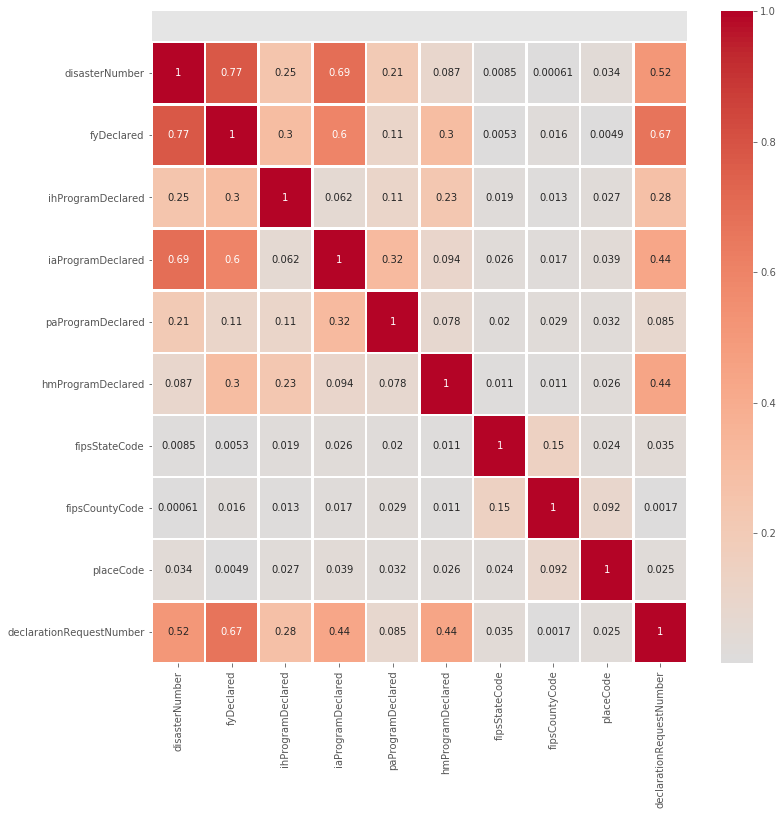

In [10]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df.corr().abs(), center=0, annot=True, linewidths=1.5, cmap='coolwarm');
ax.set_ylim(len(df.corr())-0, -0.5)

# Scrub

In [11]:
df['femaDeclarationString'].value_counts()

DR-4522-ME    437
DR-1239-TX    257
DR-4485-TX    257
EM-3458-TX    257
EM-3261-TX    255
             ... 
FM-2547-CA      1
FM-2806-TX      1
DR-1449-FM      1
FM-2807-TX      1
FM-2098-CO      1
Name: femaDeclarationString, Length: 4497, dtype: int64

In [12]:
df['disasterNumber'].value_counts()

4522    437
3458    257
4485    257
1239    257
3261    255
       ... 
2993      1
5010      1
2961      1
2929      1
2049      1
Name: disasterNumber, Length: 4497, dtype: int64

In [13]:
df['state'].value_counts()

TX    4651
MO    2670
VA    2460
KY    2416
OK    2278
GA    2239
LA    2131
FL    2027
NC    1965
PR    1825
IA    1823
MS    1691
KS    1682
AL    1619
AR    1588
TN    1522
MN    1498
IN    1451
CA    1443
NE    1423
NY    1421
ND    1301
OH    1281
IL    1268
SD    1251
PA    1226
WV    1218
ME    1004
WI     891
WA     862
SC     855
MI     791
CO     642
MT     586
NJ     567
OR     562
NM     495
MD     445
MA     389
ID     346
AZ     323
VT     314
NH     294
NV     271
AK     247
UT     241
CT     228
WY     128
RI     102
HI      95
VI      79
AS      75
MP      62
MH      53
DE      52
FM      31
DC      22
GU      19
PW       1
Name: state, dtype: int64

In [14]:
df['declarationType'].value_counts()

DR    40964
EM    17696
FM     1780
Name: declarationType, dtype: int64

In [15]:
df['declarationDate'].value_counts()

2020-03-13T20:00:00.000Z    2876
2020-03-13T19:00:00.000Z     566
1996-01-13T05:00:00.000Z     453
2020-04-04T17:15:00.000Z     437
2005-09-13T17:34:00.000Z     433
                            ... 
1955-08-15T04:00:00.000Z       1
1999-09-01T01:25:00.000Z       1
2016-11-29T04:00:00.000Z       1
2009-03-06T01:04:00.000Z       1
2020-10-26T19:59:00.000Z       1
Name: declarationDate, Length: 3849, dtype: int64

In [16]:
df['declarationDate'] = df['declarationDate'].str.split('T').str[0]

In [17]:
df['declarationDate'].value_counts()

2020-03-13    3683
2005-09-11     777
2020-04-04     738
2005-09-05     646
2005-09-13     615
              ... 
1997-12-24       1
1982-08-19       1
2017-02-13       1
2008-06-21       1
1994-04-23       1
Name: declarationDate, Length: 3118, dtype: int64

In [18]:
df['declarationDate'] = pd.to_datetime(df['declarationDate'])

In [19]:
# df['Declaration Day of Week'] = df['declarationDate'].dt.day_name()

In [20]:
#df['Declaration Year'] = df['declarationDate'].dt.year
#df['Declaration Month'] = df['declarationDate'].dt.month
#df['Declaration Day'] = df['declarationDate'].dt.day

In [21]:
#df = df.drop(columns=['declarationDate'], axis=1)

In [22]:
df.head()

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,hash,lastRefresh,id
0,DR-1-GA,1,GA,DR,1953-05-02,1953,Tornado,TORNADO,0,1,1,1,1953-05-02T04:00:00.000Z,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,2f28952448e0a666d367ca3f854c81ec,2020-10-05T14:21:20.694Z,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15T04:00:00.000Z,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,c5a1a4a1030d6730d9c562cdbe7c830f,2020-10-05T14:21:20.696Z,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06T04:00:00.000Z,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,59c5483387ca13c6a3c1bc692f4860e1,2020-10-05T14:21:20.698Z,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11,1953,Tornado,TORNADO,0,1,1,1,1953-06-11T04:00:00.000Z,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,6bab17e16984fc75f61a8445df3e95d9,2020-10-05T14:21:20.699Z,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11T04:00:00.000Z,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,e258e9dd25fac73939f59c8ffb5308f5,2020-10-05T14:21:20.700Z,5f7b2be031a8c6681cfb434e


In [23]:
df['fyDeclared'].value_counts()

2020    9243
2005    4661
2011    2684
2008    2456
2019    1902
        ... 
1960      13
1961      11
1953      10
1959       7
1958       6
Name: fyDeclared, Length: 69, dtype: int64

In [24]:
df['incidentType'].value_counts()

Severe Storm(s)     16957
Hurricane           11890
Flood               10389
Biological           7611
Snow                 3659
Fire                 3488
Severe Ice Storm     1990
Tornado              1464
Drought              1292
Coastal Storm         570
Freezing              301
Other                 297
Earthquake            226
Typhoon               130
Volcano                51
Fishing Losses         42
Mud/Landslide          31
Dam/Levee Break        13
Toxic Substances        9
Tsunami                 9
Chemical                9
Human Cause             7
Terrorist               5
Name: incidentType, dtype: int64

In [25]:
df['declarationTitle'].value_counts()

COVID-19 PANDEMIC               3928
SEVERE STORMS AND FLOODING      3810
COVID-19                        3683
SEVERE STORMS & FLOODING        3387
HURRICANE KATRINA EVACUATION    2602
                                ... 
DOLAN FIRE                         1
BENTON CITY FIRE                   1
MCKINLEY FIRE                      1
WHITE SALMON FIRE                  1
ALMEDA GLENDOWER FIRE              1
Name: declarationTitle, Length: 2136, dtype: int64

In [26]:
# We can combine COVID into one category as it's listed as two different categories
df['declarationTitle'].replace('COVID-19', 'COVID-19 PANDEMIC', inplace=True)
df['declarationTitle'].replace('SEVERE STORMS & FLOODING', 'SEVERE STORMS AND FLOODING', inplace=True)
df['declarationTitle'].value_counts()

COVID-19 PANDEMIC                         7611
SEVERE STORMS AND FLOODING                7197
HURRICANE KATRINA EVACUATION              2602
SEVERE WINTER STORM                       1935
SEVERE STORMS, TORNADOES, AND FLOODING    1849
                                          ... 
BENTON CITY FIRE                             1
MCKINLEY FIRE                                1
WHITE SALMON FIRE                            1
DOLAN FIRE                                   1
ALMEDA GLENDOWER FIRE                        1
Name: declarationTitle, Length: 2134, dtype: int64

In [27]:
#df = df.set_index("declarationTitle")
#df= df.drop('COVID-19 PANDEMIC', axis=0)

In [28]:
df['ihProgramDeclared'].value_counts()

0    50440
1    10000
Name: ihProgramDeclared, dtype: int64

In [29]:
df['iaProgramDeclared'].value_counts()

0    43253
1    17187
Name: iaProgramDeclared, dtype: int64

In [30]:
df['paProgramDeclared'].value_counts()

1    56309
0     4131
Name: paProgramDeclared, dtype: int64

In [31]:
df['hmProgramDeclared'].value_counts()

0    39029
1    21411
Name: hmProgramDeclared, dtype: int64

In [32]:
df['incidentBeginDate'].value_counts()

2020-01-20T19:00:00.000Z    7310
2005-08-29T04:00:00.000Z    1959
1993-03-13T05:00:00.000Z     771
1996-01-06T05:00:00.000Z     415
2005-11-27T05:00:00.000Z     380
                            ... 
1987-07-16T04:00:00.000Z       1
1985-08-07T04:00:00.000Z       1
2014-09-07T04:00:00.000Z       1
2009-08-28T00:00:00.000Z       1
1961-03-31T05:00:00.000Z       1
Name: incidentBeginDate, Length: 3364, dtype: int64

In [33]:
df['incidentBeginDate'] = df['incidentBeginDate'].str.split('T').str[0]

In [34]:
#df['incidentBeginDate'] = pd.to_datetime(df['incidentBeginDate'])

In [35]:
#df['Begin Day of Week'] = df['incidentBeginDate'].dt.day_name()

In [36]:
#df['Begin Incident Year'] = df['incidentBeginDate'].dt.year
#df['Begin Incident Month'] = df['incidentBeginDate'].dt.month
#df['Begin Incident Day'] = df['incidentBeginDate'].dt.day

In [37]:
#df = df.drop(columns=['incidentBeginDate'], axis=1)
#df.head()

In [38]:
df['incidentEndDate'].value_counts()

2005-10-01T12:55:00.000Z    2926
1993-03-17T05:00:00.000Z     635
1996-01-12T05:00:00.000Z     555
2017-09-21T03:59:00.000Z     321
2012-11-08T05:00:00.000Z     307
                            ... 
1998-11-03T05:00:00.000Z       1
2018-03-17T03:59:00.000Z       1
2006-06-19T00:00:00.000Z       1
2011-10-11T04:00:00.000Z       1
2016-07-12T12:00:00.000Z       1
Name: incidentEndDate, Length: 3174, dtype: int64

In [39]:
#df['incidentEndDate'] = df['incidentEndDate'].str.split('T').str[0]

In [40]:
#df['incidentEndDate'] = pd.to_datetime(df['incidentEndDate'])

In [41]:
#df['Incident End Day of Week'] = df['incidentEndDate'].dt.day_name()

In [42]:
#df['Incident End Year'] = df['incidentEndDate'].dt.year
#df['Incident End Month'] = df['incidentEndDate'].dt.month
#df['Incident End Day'] = df['incidentEndDate'].dt.day

In [43]:
#df = df.drop(columns=['incidentEndDate'], axis=1)
df.head()

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,hash,lastRefresh,id
0,DR-1-GA,1,GA,DR,1953-05-02,1953,Tornado,TORNADO,0,1,1,1,1953-05-02,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,2f28952448e0a666d367ca3f854c81ec,2020-10-05T14:21:20.694Z,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,c5a1a4a1030d6730d9c562cdbe7c830f,2020-10-05T14:21:20.696Z,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,59c5483387ca13c6a3c1bc692f4860e1,2020-10-05T14:21:20.698Z,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11,1953,Tornado,TORNADO,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,6bab17e16984fc75f61a8445df3e95d9,2020-10-05T14:21:20.699Z,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,e258e9dd25fac73939f59c8ffb5308f5,2020-10-05T14:21:20.700Z,5f7b2be031a8c6681cfb434e


In [44]:
df['disasterCloseoutDate'].value_counts()

2020-04-22T03:59:00.000Z    674
2017-12-19T04:59:00.000Z    430
1994-06-30T04:00:00.000Z    410
1978-07-03T04:00:00.000Z    393
2001-09-18T04:00:00.000Z    390
                           ... 
2016-07-07T03:59:00.000Z      1
1956-04-30T04:00:00.000Z      1
1999-08-26T04:00:00.000Z      1
1966-04-08T05:00:00.000Z      1
2002-12-17T05:00:00.000Z      1
Name: disasterCloseoutDate, Length: 1755, dtype: int64

In [45]:
#df['disasterCloseoutDate'] = df['disasterCloseoutDate'].str.split('T').str[0]

In [46]:
#df['disasterCloseoutDate'] = pd.to_datetime(df['disasterCloseoutDate'])

In [47]:
#df['Disaster Close Day of Week'] = df['disasterCloseoutDate'].dt.day_name()

In [48]:
#df['Disaster Close Year'] = df['disasterCloseoutDate'].dt.year
#df['Disaster Close Month'] = df['disasterCloseoutDate'].dt.month
#df['Disaster Close Day'] = df['disasterCloseoutDate'].dt.day

In [49]:
#df = df.drop(columns=['disasterCloseoutDate'], axis=1)
df.head()

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,hash,lastRefresh,id
0,DR-1-GA,1,GA,DR,1953-05-02,1953,Tornado,TORNADO,0,1,1,1,1953-05-02,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,2f28952448e0a666d367ca3f854c81ec,2020-10-05T14:21:20.694Z,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,c5a1a4a1030d6730d9c562cdbe7c830f,2020-10-05T14:21:20.696Z,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,59c5483387ca13c6a3c1bc692f4860e1,2020-10-05T14:21:20.698Z,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11,1953,Tornado,TORNADO,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,6bab17e16984fc75f61a8445df3e95d9,2020-10-05T14:21:20.699Z,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,e258e9dd25fac73939f59c8ffb5308f5,2020-10-05T14:21:20.700Z,5f7b2be031a8c6681cfb434e


In [50]:
df['fipsStateCode'].value_counts()

48    4651
29    2670
51    2460
21    2416
40    2278
13    2239
22    2131
12    2027
37    1965
72    1825
19    1823
28    1691
20    1682
1     1619
5     1588
47    1522
27    1498
18    1451
6     1443
31    1423
36    1421
38    1301
39    1281
17    1268
46    1251
42    1226
54    1218
23    1004
55     891
53     862
45     855
26     791
8      642
30     586
34     567
41     562
35     495
24     445
25     389
16     346
4      323
50     314
33     294
32     271
2      247
49     241
9      228
56     128
44     102
15      95
78      79
60      75
69      62
68      53
10      52
64      31
11      22
66      19
70       1
Name: fipsStateCode, dtype: int64

In [51]:
df['fipsCountyCode'].value_counts()

0      1333
3       994
5       962
7       949
9       933
       ... 
390       2
230       1
400       1
80        1
330       1
Name: fipsCountyCode, Length: 345, dtype: int64

In [52]:
df['placeCode'].value_counts()

99005    937
99009    917
99001    913
99007    896
99015    885
        ... 
72200      1
99400      1
99080      1
56240      1
48440      1
Name: placeCode, Length: 1109, dtype: int64

In [53]:
df['designatedArea'].value_counts()

Washington (County)     517
Jefferson (County)      471
Statewide               465
Jackson (County)        455
Franklin (County)       445
                       ... 
T07 R17 WELS              1
Valley (Township of)      1
T02 R09 NWP               1
T09 R16 WELS              1
Fayette                   1
Name: designatedArea, Length: 2769, dtype: int64

In [54]:
df['declarationRequestNumber'].value_counts()

20130    437
98062    257
20061    257
20080    257
5137     255
        ... 
8115       1
6066       1
6034       1
98175      1
2049       1
Name: declarationRequestNumber, Length: 4497, dtype: int64

In [55]:
df['hash'].value_counts()

d363c5e683a324a8cad2a299edcbbca6    1
d078d3edef86bd3fb636d32f84cdb03c    1
4d432155ff100acaff7de43a909a0bc2    1
71f9c8c3702318825146e832809644ba    1
132340079fe715b9b8724edcc1a046a1    1
                                   ..
ef2a4b26b0828a748d8fa82ce3f27dca    1
b4f7ff05f44293dbabacb072dec558a0    1
53928a79fd9fd92fa9a9a273ef933721    1
4204b978a78fb94f9cb71adeb088e60f    1
1b0edb19949c72ea541cac5e1f5d538a    1
Name: hash, Length: 60440, dtype: int64

In [56]:
df = df.drop(columns=['hash'], axis=1)
df

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,lastRefresh,id
0,DR-1-GA,1,GA,DR,1953-05-02,1953,Tornado,TORNADO,0,1,1,1,1953-05-02,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,2020-10-05T14:21:20.694Z,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,2020-10-05T14:21:20.696Z,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,2020-10-05T14:21:20.698Z,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11,1953,Tornado,TORNADO,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,2020-10-05T14:21:20.699Z,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,2020-10-05T14:21:20.700Z,5f7b2be031a8c6681cfb434e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60435,FM-5382-NV,5382,NV,FM,2020-11-18,2021,Fire,PINEHAVEN FIRE,0,0,1,1,2020-11-17,NaN,NaN,32,31,99031,Washoe (County),20323,2020-11-19T16:42:40.333Z,5fb6a0800eb5d36238b4d770
60436,DR-4569-CA,4569,CA,DR,2020-10-17,2021,Fire,WILDFIRES,0,0,1,1,2020-09-04,2020-11-18T04:00:00.000Z,NaN,6,15,99015,Del Norte (County),20302,2020-11-25T20:42:27.057Z,5fbec1b30eb5d36238660eac
60437,DR-4569-CA,4569,CA,DR,2020-10-17,2021,Fire,WILDFIRES,0,0,1,1,2020-09-04,2020-11-18T04:00:00.000Z,NaN,6,115,99115,Yuba (County),20302,2020-11-25T20:42:27.058Z,5fbec1b30eb5d36238660ebd
60438,DR-4566-DE,4566,DE,DR,2020-10-02,2021,Hurricane,TROPICAL STORM ISAIAS,0,0,1,1,2020-08-05,2020-08-08T03:59:00.000Z,NaN,10,3,99003,New Castle (County),20253,2020-12-02T21:41:43.367Z,5fc80a170eb5d36238431c13


In [57]:
# This column is just showing us when the data was last refreshed so we can drop
df['lastRefresh'].value_counts()

2020-10-05T14:21:20.707Z    6
2020-10-05T14:21:20.705Z    6
2020-10-05T14:21:20.709Z    5
2020-10-05T14:21:20.708Z    5
2020-10-05T14:21:20.706Z    5
                           ..
2020-10-05T14:22:35.137Z    1
2020-10-05T14:22:09.676Z    1
2020-10-05T14:21:33.539Z    1
2020-10-05T14:21:35.690Z    1
2020-10-05T14:21:31.149Z    1
Name: lastRefresh, Length: 51842, dtype: int64

In [58]:
df = df.drop(columns=['lastRefresh'], axis=1)
df

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,id
0,DR-1-GA,1,GA,DR,1953-05-02,1953,Tornado,TORNADO,0,1,1,1,1953-05-02,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11,1953,Tornado,TORNADO,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,5f7b2be031a8c6681cfb434e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60435,FM-5382-NV,5382,NV,FM,2020-11-18,2021,Fire,PINEHAVEN FIRE,0,0,1,1,2020-11-17,NaN,NaN,32,31,99031,Washoe (County),20323,5fb6a0800eb5d36238b4d770
60436,DR-4569-CA,4569,CA,DR,2020-10-17,2021,Fire,WILDFIRES,0,0,1,1,2020-09-04,2020-11-18T04:00:00.000Z,NaN,6,15,99015,Del Norte (County),20302,5fbec1b30eb5d36238660eac
60437,DR-4569-CA,4569,CA,DR,2020-10-17,2021,Fire,WILDFIRES,0,0,1,1,2020-09-04,2020-11-18T04:00:00.000Z,NaN,6,115,99115,Yuba (County),20302,5fbec1b30eb5d36238660ebd
60438,DR-4566-DE,4566,DE,DR,2020-10-02,2021,Hurricane,TROPICAL STORM ISAIAS,0,0,1,1,2020-08-05,2020-08-08T03:59:00.000Z,NaN,10,3,99003,New Castle (County),20253,5fc80a170eb5d36238431c13


In [59]:
df['id'].value_counts()

5f7b2c3131a8c6681cffef74    1
5f7b2c3031a8c6681cffe29e    1
5f7b2bec31a8c6681cfbce8c    1
5f7b2c0731a8c6681cfd63ce    1
5f7b2bed31a8c6681cfbda47    1
                           ..
5f7b2c3131a8c6681cfff852    1
5f7b2c0531a8c6681cfd3e08    1
5f7b2c0231a8c6681cfd0d26    1
5f7b2c0831a8c6681cfd79fb    1
5f7b2bfe31a8c6681cfcbf8f    1
Name: id, Length: 60440, dtype: int64

# Data Preparation (Preparing for Modeling)

In [60]:
# Finding the top 3 Natural Disasters
# We will make vizualizations of these
natdisasters = list(df['incidentType'].value_counts().head(1).index)
natdisasters

['Severe Storm(s)']

In [61]:
df = df[df['incidentType'].isin(natdisasters)]
df['incidentType'].value_counts()

Severe Storm(s)    16957
Name: incidentType, dtype: int64

In [62]:
df.head()

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,id
52,DR-56-NC,56,NC,DR,1956-04-24,1956,Severe Storm(s),SEVERE STORM,0,1,1,1,1956-04-24,1956-04-24T05:00:00.000Z,1957-09-01T04:00:00.000Z,37,0,0,Statewide,56009,5f7b2be031a8c6681cfb4410
55,DR-61-PA,61,PA,DR,1956-08-09,1956,Severe Storm(s),STORM,0,1,1,1,1956-08-09,1956-08-09T04:00:00.000Z,1959-06-01T04:00:00.000Z,42,0,0,Statewide,56016,5f7b2be031a8c6681cfb4416
59,DR-58-PA,58,PA,DR,1956-05-21,1956,Severe Storm(s),SEVERE STORM,0,1,1,1,1956-05-21,1956-05-21T04:00:00.000Z,1959-06-01T04:00:00.000Z,42,0,0,Statewide,56015,5f7b2be031a8c6681cfb441e
97,DR-103-TX,103,TX,DR,1960-07-15,1960,Severe Storm(s),"HEAVY RAINS, HAIL, FLOODS & TORNADOES",0,1,1,1,1960-07-15,1960-07-15T04:00:00.000Z,1962-10-04T04:00:00.000Z,48,0,0,Statewide,60022,5f7b2be031a8c6681cfb4484
102,DR-104-OK,104,OK,DR,1960-07-15,1960,Severe Storm(s),"HEAVY RAINS, HAIL, FLOODS & TORNADOES",0,1,1,1,1960-07-15,1960-07-15T04:00:00.000Z,1962-03-20T05:00:00.000Z,40,0,0,Statewide,60021,5f7b2be031a8c6681cfb44d4


In [63]:
severestorm = list(df['incidentType'].value_counts().head(1).index)
severestorm

['Severe Storm(s)']

In [64]:
# Make Date the index 
df['date'] = pd.to_datetime(df['declarationDate'])
df.set_index('date', inplace=True)
df

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,id
date,,,,,,,,,,,,,,,,,,,,,
1956-04-24,DR-56-NC,56,NC,DR,1956-04-24,1956,Severe Storm(s),SEVERE STORM,0,1,1,1,1956-04-24,1956-04-24T05:00:00.000Z,1957-09-01T04:00:00.000Z,37,0,0,Statewide,56009,5f7b2be031a8c6681cfb4410
1956-08-09,DR-61-PA,61,PA,DR,1956-08-09,1956,Severe Storm(s),STORM,0,1,1,1,1956-08-09,1956-08-09T04:00:00.000Z,1959-06-01T04:00:00.000Z,42,0,0,Statewide,56016,5f7b2be031a8c6681cfb4416
1956-05-21,DR-58-PA,58,PA,DR,1956-05-21,1956,Severe Storm(s),SEVERE STORM,0,1,1,1,1956-05-21,1956-05-21T04:00:00.000Z,1959-06-01T04:00:00.000Z,42,0,0,Statewide,56015,5f7b2be031a8c6681cfb441e
1960-07-15,DR-103-TX,103,TX,DR,1960-07-15,1960,Severe Storm(s),"HEAVY RAINS, HAIL, FLOODS & TORNADOES",0,1,1,1,1960-07-15,1960-07-15T04:00:00.000Z,1962-10-04T04:00:00.000Z,48,0,0,Statewide,60022,5f7b2be031a8c6681cfb4484
1960-07-15,DR-104-OK,104,OK,DR,1960-07-15,1960,Severe Storm(s),"HEAVY RAINS, HAIL, FLOODS & TORNADOES",0,1,1,1,1960-07-15,1960-07-15T04:00:00.000Z,1962-03-20T05:00:00.000Z,40,0,0,Statewide,60021,5f7b2be031a8c6681cfb44d4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-02,DR-4565-ND,4565,ND,DR,2020-10-02,2021,Severe Storm(s),SEVERE STORMS AND FLOODING,0,0,1,1,2020-06-29,2020-07-01T04:00:00.000Z,NaN,38,5,99005,Benson (County),20254,5f7b2c3131a8c6681cfffa45
2020-10-02,DR-4565-ND,4565,ND,DR,2020-10-02,2021,Severe Storm(s),SEVERE STORMS AND FLOODING,0,0,1,1,2020-06-29,2020-07-01T04:00:00.000Z,NaN,38,53,99053,McKenzie (County),20254,5f7b2c3131a8c6681cfffa5f
2020-10-02,DR-4565-ND,4565,ND,DR,2020-10-02,2021,Severe Storm(s),SEVERE STORMS AND FLOODING,0,0,1,1,2020-06-29,2020-07-01T04:00:00.000Z,NaN,38,61,99061,Mountrail (County),20254,5f7b2c3131a8c6681cfffa62


In [65]:
# The 'MS' string groups the data in buckets by start of the month
df.groupby(['incidentType']).resample('MS').count()['id']

incidentType     date      
Severe Storm(s)  1956-04-01     1
                 1956-05-01     1
                 1956-06-01     0
                 1956-07-01     0
                 1956-08-01     1
                               ..
                 2020-06-01     0
                 2020-07-01    68
                 2020-08-01    23
                 2020-09-01     1
                 2020-10-01     6
Name: id, Length: 775, dtype: int64

In [66]:
freq = 'MS'

In [67]:
pd.date_range(start='1953-05-01', end='2020-01-01')

DatetimeIndex(['1953-05-01', '1953-05-02', '1953-05-03', '1953-05-04',
               '1953-05-05', '1953-05-06', '1953-05-07', '1953-05-08',
               '1953-05-09', '1953-05-10',
               ...
               '2019-12-23', '2019-12-24', '2019-12-25', '2019-12-26',
               '2019-12-27', '2019-12-28', '2019-12-29', '2019-12-30',
               '2019-12-31', '2020-01-01'],
              dtype='datetime64[ns]', length=24352, freq='D')

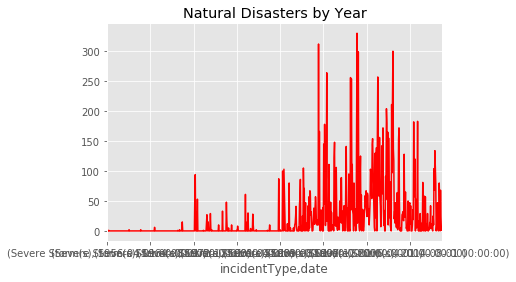

In [68]:
ts_natdisasters = df.groupby(['incidentType']).resample(freq).count()['id']
ts_natdisasters.plot.line(color='red')
plt.title('Natural Disasters by Year')
plt.savefig('natdisasters-by-year')
plt.show()

In [69]:
natdisasters

['Severe Storm(s)']

In [70]:
#natdisasters.drop('Biological')

In [71]:
# Severe Storm(s)

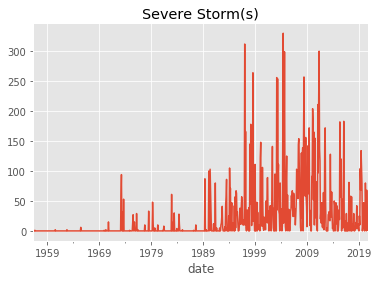

In [72]:
sstorms = {}
for disaster in natdisasters:
    ts = ts_natdisasters[disaster].asfreq(freq).rename(disaster)
    plt.figure()
    ts.plot(title=disaster)
    sstorms[disaster] = ts

In [73]:
df = pd.DataFrame(sstorms) 
df

,Severe Storm(s)
date,
1956-04-01,1
1956-05-01,1
1956-06-01,0
1956-07-01,0
1956-08-01,1
...,...
2020-06-01,0
2020-07-01,68
2020-08-01,23


In [74]:
#sstorms = sstorms.drop(['Biological']) 

In [75]:
df.fillna(0, inplace=True)

In [76]:
df.index

DatetimeIndex(['1956-04-01', '1956-05-01', '1956-06-01', '1956-07-01',
               '1956-08-01', '1956-09-01', '1956-10-01', '1956-11-01',
               '1956-12-01', '1957-01-01',
               ...
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', name='date', length=775, freq='MS')

# Vizualizations for Non-Technical Audience

In [77]:
#df['Fire']

In [78]:
# Look at Lab for sampling
# MS or ME

In [79]:
## Making into df after running for loop
## Rewatching office hours video - forcasting
## Deleting biological
## Specific periods of time of year

In [80]:
# sstorms = df[df['incidentType'] == 'Severe Storm(s)']
# sstorms

In [81]:
#ts_sstorms = sstorms.resample('A').count()['id']
#ts_sstorms.plot.line(color='red')
##plt.savefig('severestorms-by-year')
#plt.show()

In [82]:
#hurricanes = df[df['incidentType'] =='Hurricane']
#hurricanes

In [83]:
#hurricanes.nunique()

In [84]:
#ts_hurricanes = hurricanes.resample('A').count()['id']
#ts_hurricanes.plot.line(color='purple')
#plt.title('Hurricanes by Year')
#plt.savefig('hurricanes-by-year')
#plt.show()

In [85]:
# Plotting the cumulation of hurricanes
#ts_hurricanes.cumsum().plot()

In [86]:
# Flood

In [87]:
#floods = df[df['incidentType'] =='Flood']
#floods

In [88]:
#ts_flood = floods.resample('A').count()['id']
#ts_flood.plot.line(color='blue')
#plt.title('Floods by Year')
#plt.savefig('floods-by-year')
#plt.show()

In [89]:
# Biological

In [90]:
#Biological = df[df['incidentType'] =='Biological']
#Biological

In [91]:
#ts_Biological = Biological.resample('MS').count()['id']
#ts_Biological.plot.line(color='orange')
#plt.title('Biological by Year')
#plt.savefig('Biological-by-year')
#plt.show()

In [92]:
# Bio is COVID
# Not include in this model

In [93]:
# Snow

In [94]:
#Snow = df[df['incidentType'] =='Snow']
#Snow

In [95]:
#ts_Snow = Snow.resample('A').count()['id']
#ts_Snow.plot.line(color='orange')
#plt.title('Snow by Year')
#plt.savefig('Snow-by-year')
#plt.show()

In [96]:
#'Fire'

In [97]:
#Fire = df[df['incidentType'] =='Fire']
#Fire

In [98]:
#ts_Fire = Fire.resample('A').count()['id']
#ts_Fire.plot.line(color='red')
#plt.title('Fire by Year')
#plt.savefig('Fire-by-year')
#plt.show()

In [99]:
#'Severe Ice Storm'

In [100]:
#Ice = df[df['incidentType'] =='Severe Ice Storm']
#Ice

In [101]:
#ts_Ice = Ice.resample('A').count()['id']
#ts_Ice.plot.line(color='blue')
#plt.title('Ice by Year')
#plt.savefig('Ice-by-year')
#plt.show()

In [102]:
#'Tornado'

In [103]:
#Tornado = df[df['incidentType'] =='Tornado']
#Tornado

In [104]:
#ts_Tornado = Tornado.resample('A').count()['id']
#ts_Tornado.plot.line(color='orange')
#plt.title('Tornado by Year')
#plt.savefig('Tornado-by-year')
#plt.show()

# Modeling

In [105]:
# One of the most common methods used in time series forecasting is known as the ARIMA model, 
# which stands for AutoregRessive Integrated Moving Average. 
# ARIMA is a model that can be fitted to time series data in order to 
# better understand or predict future points in the series.

In [106]:
# Defining (p,d,q)
# p = auto-regressive part of model. Incorporates the effect of past values into our model.
# d = Integrated component of an ARIMA model. Concerned with the amount of differencing 
# as it identifies the number of lag values to subtract from the current observation.  
# q = Moving average part of the model. Used to set the error of the model as a 
# linear combination of the error values observed at previous time point in the past.
# ARIMA(p,d,q) = seasonality, trend, and noise in datasets

In [107]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [108]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_natdisasters,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =8298.192893826115
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =8040.916702726013
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =8168.361684807872
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =7730.3726171532735
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =7967.076203949631
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =7841.941128568544
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =7902.415280600185
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =7731.598958404081
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =8134.43127403524
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =7939.095371953137
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =8140.601024179337
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =7691.962477127088
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =7912.551877745274
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =7802.437558476519
ARIMA (0, 0, 1) x (1

In [109]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic          7637.902
Name: 59, dtype: object

In [110]:
df.index

DatetimeIndex(['1956-04-01', '1956-05-01', '1956-06-01', '1956-07-01',
               '1956-08-01', '1956-09-01', '1956-10-01', '1956-11-01',
               '1956-12-01', '1957-01-01',
               ...
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', name='date', length=775, freq='MS')

In [111]:
# (1,1,1) is the optimal parameter values that we will now use for our SARIMAX model

ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts_natdisasters, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1487      0.026      5.750      0.000       0.098       0.199
ma.L1         -0.9479      0.010    -92.741      0.000      -0.968      -0.928
ma.S.L12      -1.0779      0.011    -94.269      0.000      -1.100      -1.055
sigma2      1324.9141     38.608     34.317      0.000    1249.243    1400.585


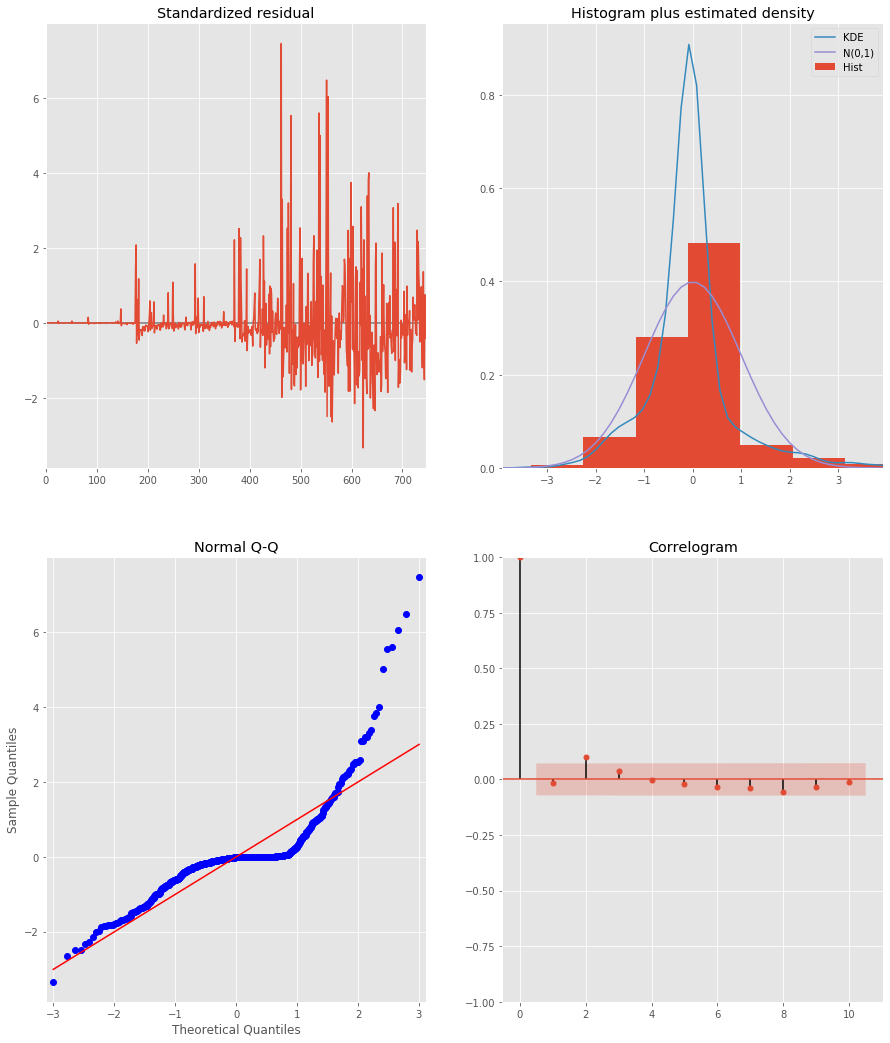

In [112]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [113]:
# The Histogram KDE line and N(0,1) are not matching well at all. 
# This is an indication that the resuduals are not normally distrubuted.
# The QQ plot is not the worst but we could find some improvements
# Standarized residual is not bad except for one spot where there is obvious noise

In [114]:
# Get predictions starting from 01-01-2010 and calculate confidence intervals
pred = output.get_prediction(start_date=('1953-06-01'), dynamic=True)
pred_conf = pred.conf_int()

TypeError: ('Severe Storm(s)', Timestamp('1956-04-01 00:00:00', freq='MS')) is not a string

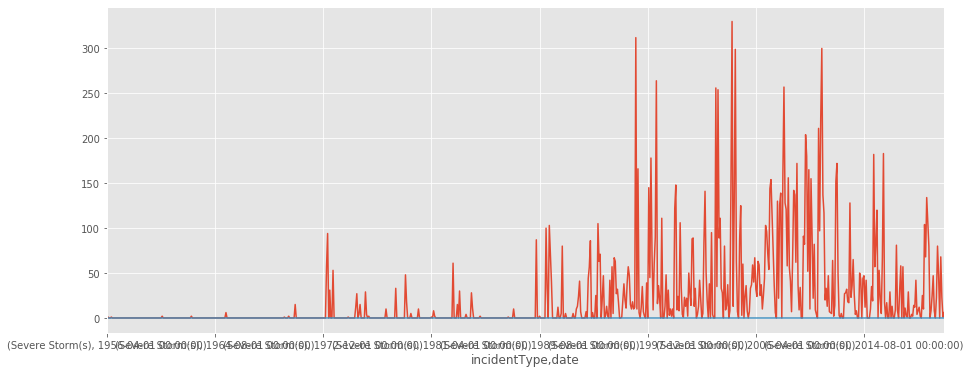

In [115]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = ts_natdisasters['1970':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Natural Disasters')
plt.legend()
plt.title('Predicted and Forcasted Natural Disasters')

plt.show()

In [ ]:
# Error message: ('Flood', Timestamp('1953-05-01 00:00:00')) is not a string
#you have a Multiindex now. You’d want to first slice out a particular disaster type. 
#Then THAT series/df will only have a normal datetime index
# We will need to slice out a particular disaster type and model them seperately

In [116]:
# Get the real and predicted values
natdisasters_forecasted = pred.predicted_mean
natdisasters_truth = ts_natdisasters['1953-06-01':]

# Compute the mean square error
mse = ((natdisasters_forecasted - natdisasters_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2642.36


In [117]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('1953-06-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

NameError: name 'pred_dynamic' is not defined

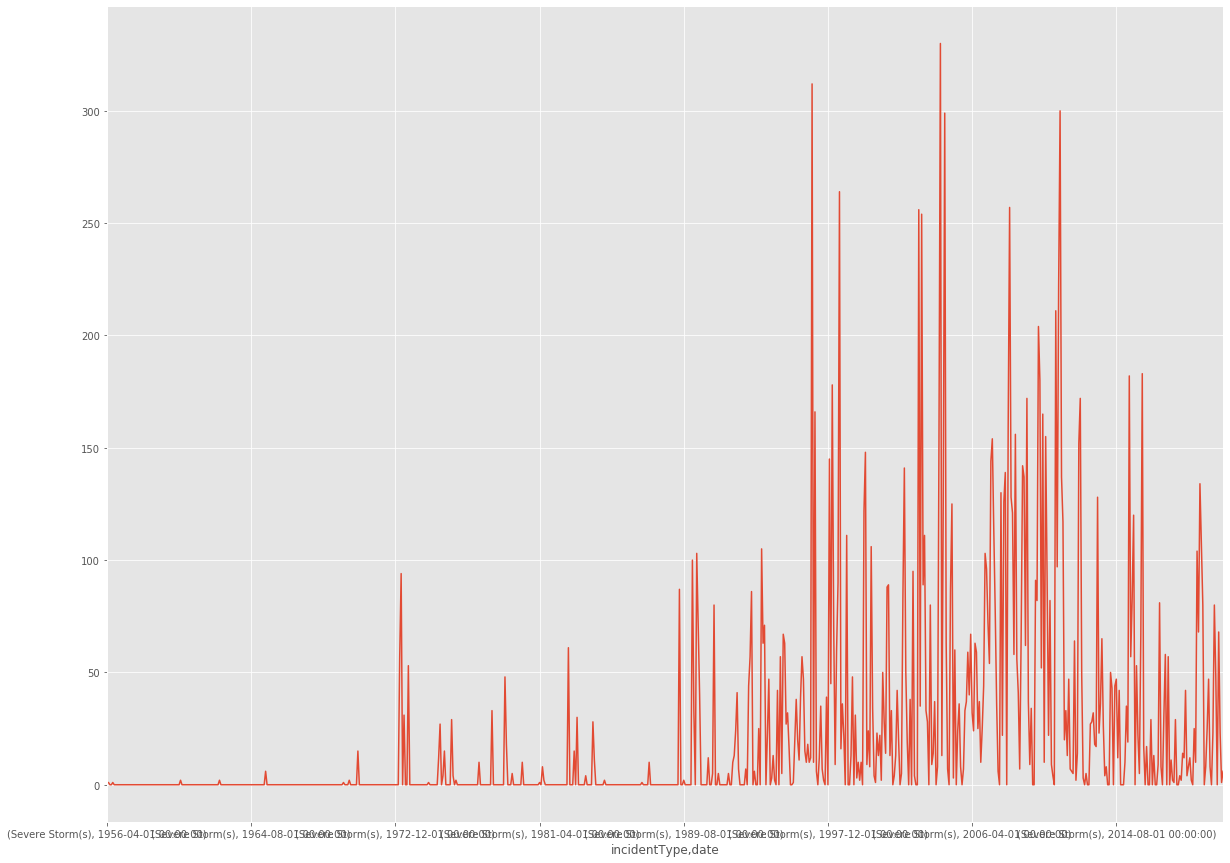

In [118]:
# Plot the dynamic forecast with confidence intervals.

ax = ts_natdisasters['1970':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1953-05-01'), natdisasters_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Natural Disasters')

plt.legend()
plt.show()

In [119]:
# Extract the predicted and true values of our time series
natdisasters_forecasted = pred_dynamic.predicted_mean
natdisasters_truth = ts_natdisasters['1953-06-01':]

# Compute the mean square error
mse = ((natdisasters_forecasted - natdisasters_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

NameError: name 'pred_dynamic' is not defined

In [120]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

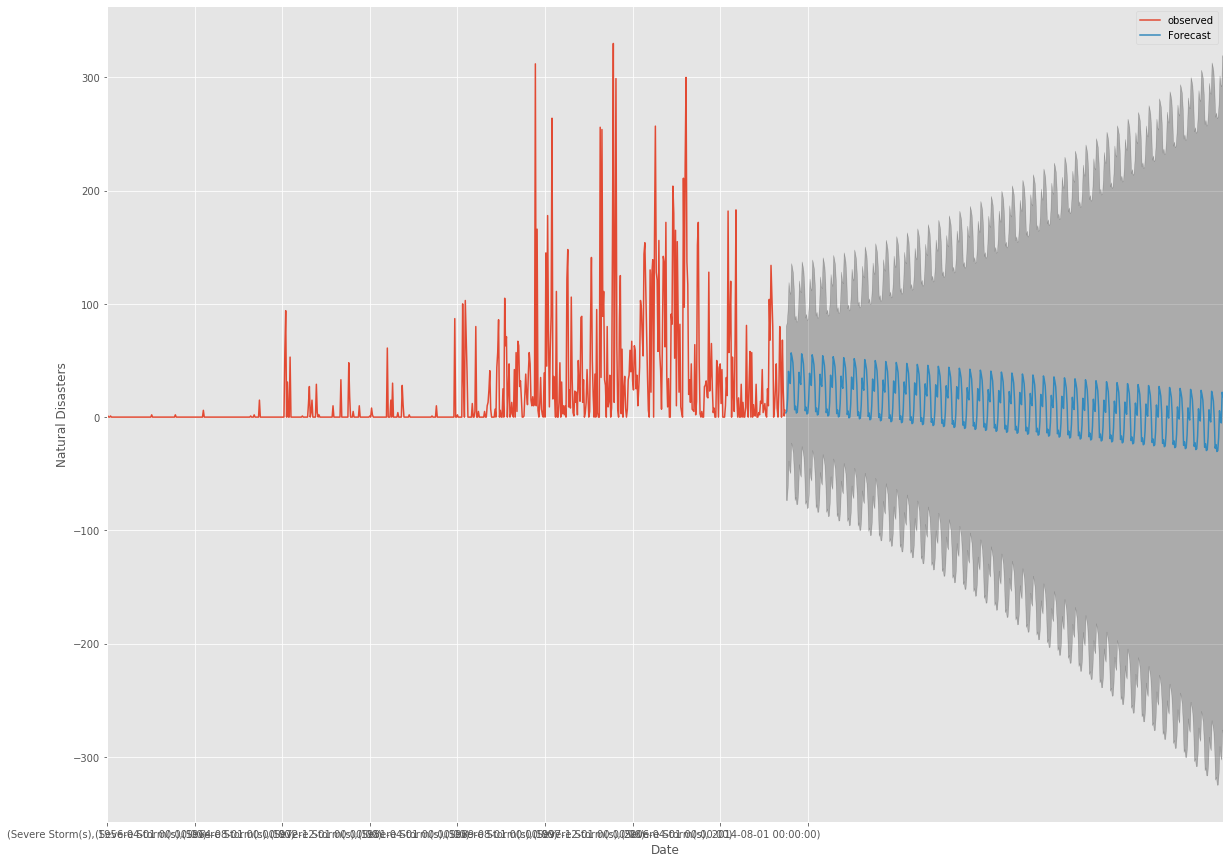

In [121]:
# Plot future predictions with confidence intervals
ax = ts_natdisasters.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Natural Disasters')

plt.legend()
plt.show()